<center><h1>MIMO CSTR Case Study</h1></center>


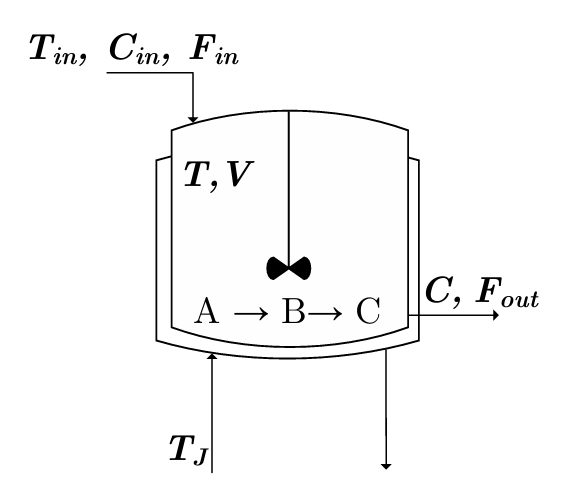

The following generalized reactions take place in the reactor, where B is the desired component 
$$  A \xrightarrow{r_a} B \xrightarrow{r_b} C  $$

We have the following system of ODEs:

$$\frac{dC_A}{dt} = \frac{F_{in}C_{A,in} - F_{out}C_A}{V} - r_a$$

$$ \frac{dC_B}{dt} = r_a - r_b - \frac{F_{out}C_B}{V} $$

$$ \frac{dC_C}{dt} = r_b - \frac{F_{out}C_C}{V} $$

$$ \frac{dT}{dt} = \frac{F_{in}(T_f - T)}{V} + \frac{\Delta H_a}{\rho C_p} r_A + \frac{\Delta H_b}{\rho C_p} r_B + \frac{UA}{V \rho C_p} (T_c - T) $$

$$ \frac{dV}{dt} = F_{in} - F_{out} $$

The three observed states of the reactor are the 1. Concentration of B $C_B$ 2. Reactor Temperature $T$ 3. Volume $V$ => Define the state vector x $x = [C_B, T, V]$

We desire a policy that maps these to the action space, comprising the 1. Cooling jacket temperature $T_c$ 2. Inlet flow rate $F_{in}$ => Define the control vector $u = [T_c, F_{in}]$

This creates a system with two PID controllers:

1. First controller pairs $T_c$ and $C_B$
2. Second controller pairs $F_{in}$ and $V$

The pairing was decided using a Relative Gain Array (RGA). This is additive measurement noise on all states of the CSTR. 

Note*: The PID controllers are not truely independent in a strict sense since the reactor is a coupled, nonlinear system:

* Changes in $T_c$ affects reaction rates, which in turn can influence $C_B$ and even the rate of volume change
* Changing $F_{in}$ affects residence time and concentrations, which can also alter temperature dynamics and thus indirectly affect how the first controller behaves

## Section 1: Model Testing

### Part 1: CSTR Model Dynamics

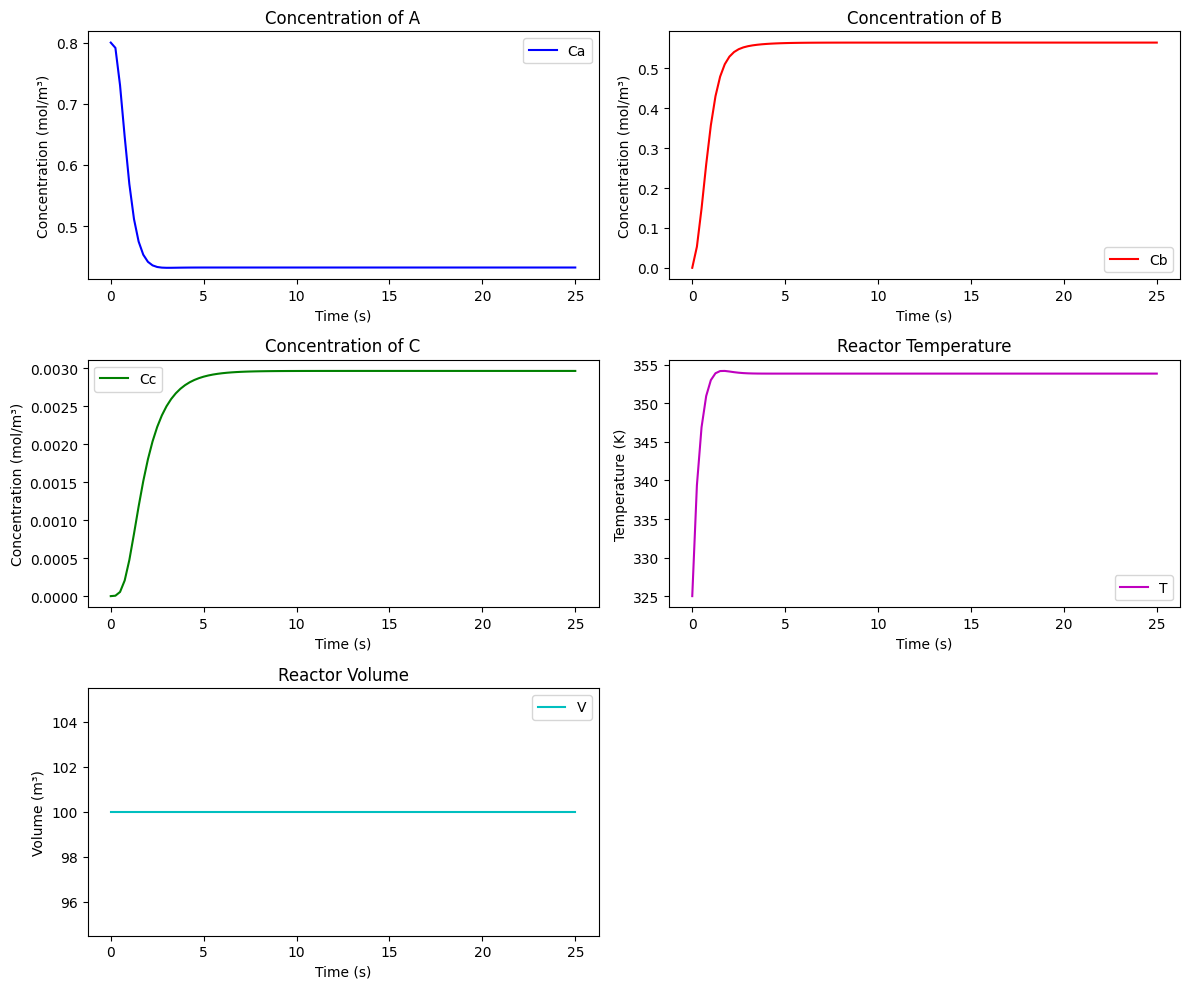

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from CSTR_model_plus import cstr_dynamics

# Define initial conditions and parameters
# State vector: [Ca, Cb, Cc, T, V]
x0 = [0.8, 0.0, 0.0, 325.0, 100.0]

# Control inputs: [Tc, Fin]
u = [350.0, 100.0]

# Feed conditions 
Tf = 350    # Feed temperature (K)
Caf = 1.0   # Feed concentration of A (mol/m^3)

# Define the time span for simulation (e.g., 0 to 100 minutes)
t = np.linspace(0, 25, 101)  # 1001 points => dt=0.1 minute

# Simulate the reactor dynamics using odeint
x = odeint(cstr_dynamics, x0, t, args=(u, Tf, Caf))

# Extract state variables from the simulation result
Ca = x[:, 0]
Cb = x[:, 1]
Cc = x[:, 2]
T  = x[:, 3]
V  = x[:, 4]

# Plot the results
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
plt.plot(t, Ca, 'b-', label='Ca')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of A')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t, Cb, 'r-', label='Cb')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of B')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(t, Cc, 'g-', label='Cc')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of C')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(t, T, 'm-', label='T')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Reactor Temperature')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t, V, 'c-', label='V')
plt.xlabel('Time (s)')
plt.ylabel('Volume (m³)')
plt.title('Reactor Volume')
plt.legend()

plt.tight_layout()
plt.show()


### Part 2: PID controller test

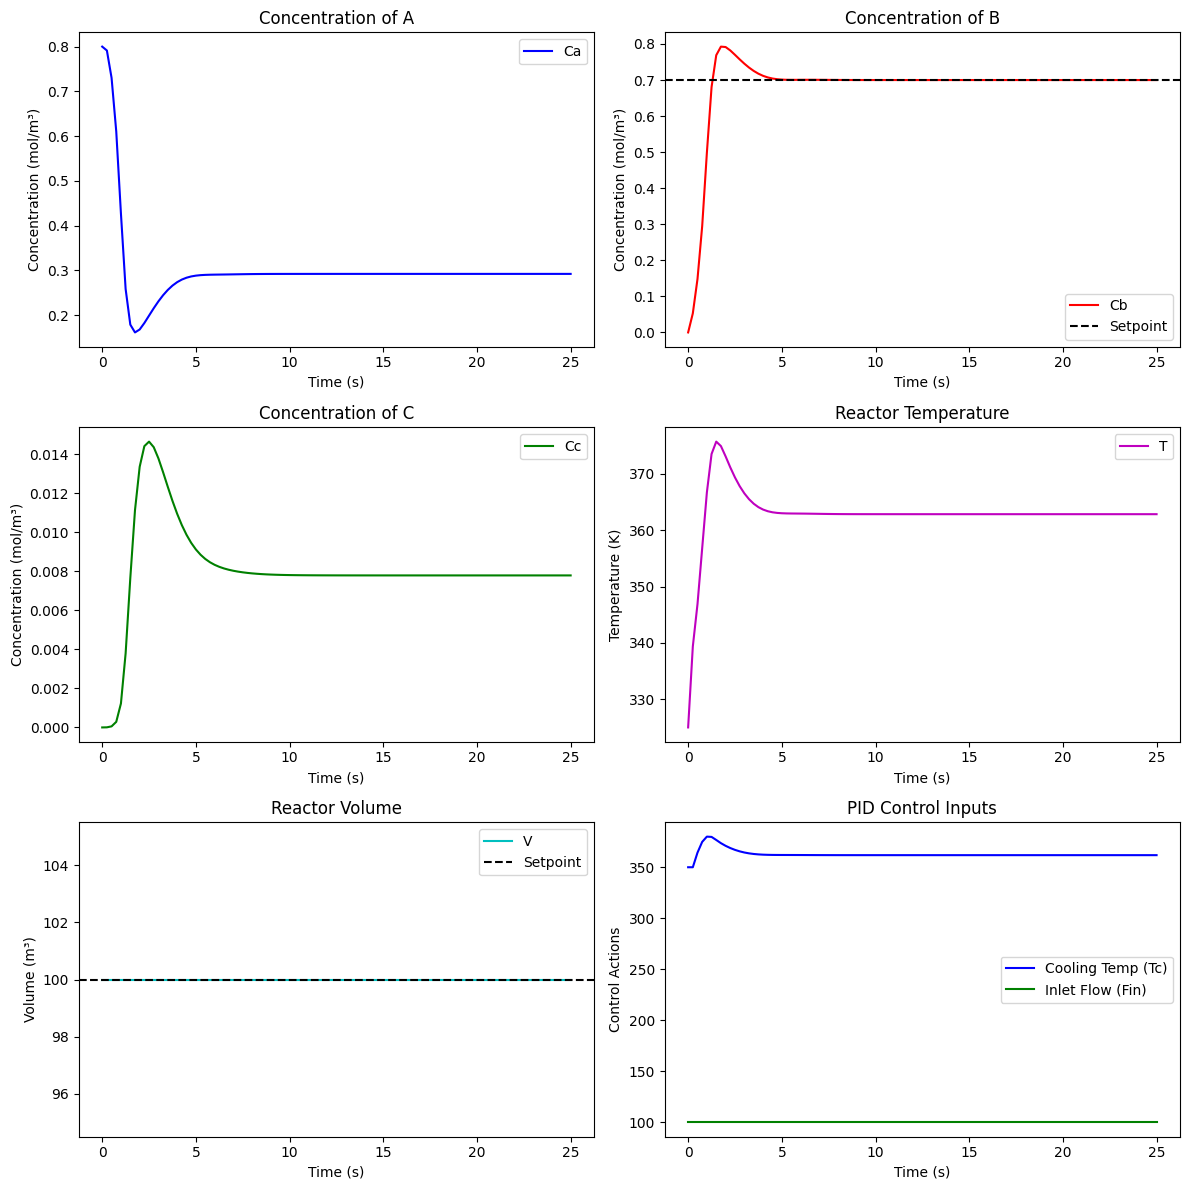

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from CSTR_model_plus import cstr_dynamics, PID_velocity 

# PID Gains 
Kp_Cb, Ki_Cb, Kd_Cb = 3.09, 0.03, 0.83
Kp_V, Ki_V, Kd_V = 0.84, 1.85, 0.08
Ks = [Kp_Cb, Ki_Cb, Kd_Cb, Kp_V, Ki_V, Kd_V]  # Combined gain array

# Initial Conditions
x0 = [0.8, 0.0, 0.0, 325.0, 100.0]  # [Ca, Cb, Cc, T, V]
u0 = [350.0, 100.0]  # Initial control inputs: [Tc, Fin]
Tf, Caf = 350, 1.0  # Feed conditions

# Setpoints
Cb_setpoint = 0.7   # Desired product B concentration
V_setpoint = 100.0  # Desired reactor volume

# Simulation Setup
t = np.linspace(0, 25, 101)  # 25 seconds
dt = t[1] - t[0]  # Time step

# Storage for results
states = np.zeros((len(t), 5))  # State variables
Tc_values, Fin_values = np.zeros(len(t)), np.zeros(len(t))  # Control actions

# PID Error History (needed for velocity PID)
e_history = [np.array([0, 0]), np.array([0, 0])]  # Store at least two previous errors
u_history = [u0, u0]  # Store previous control actions

# Simulation Loop
x = x0
for i in range(len(t)):
    # Store current state
    states[i, :] = x
    
    # Compute current errors for PID (difference from setpoint)
    e_now = np.array([Cb_setpoint - x[1], V_setpoint - x[4]])

    # Compute PID control action using velocity form
    if i < 2:
        control_action = u_history[-1]  
    else:
        control_action = PID_velocity(Ks, e_now, e_history, u_history, dt)

    # Apply physical constraints
    Tc, Fin = np.clip(control_action[0], 290, 450), np.clip(control_action[1], 95, 105)

    # Store control history
    e_history.append(e_now)
    u_history.append([Tc, Fin])
    if len(e_history) > 3:
        e_history.pop(0)
        u_history.pop(0)

    # Apply updated controls
    Tc_values[i], Fin_values[i] = Tc, Fin

    # Simulate next time step
    u = [Tc, Fin]
    x = odeint(cstr_dynamics, x, [0, dt], args=(u, Tf, Caf))[-1]

# Extract states
Ca, Cb, Cc, T, V = states.T

# Plot Results
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plt.plot(t, Ca, label='Ca', color='b')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of A')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t, Cb, label='Cb', color='r')
plt.axhline(y=Cb_setpoint, color='k', linestyle='--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of B')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(t, Cc, label='Cc', color='g')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of C')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(t, T, label='T', color='m')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Reactor Temperature')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t, V, label='V', color='c')
plt.axhline(y=V_setpoint, color='k', linestyle='--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Volume (m³)')
plt.title('Reactor Volume')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(t, Tc_values, label='Cooling Temp (Tc)', color='b')
plt.plot(t, Fin_values, label='Inlet Flow (Fin)', color='g')
plt.xlabel('Time (s)')
plt.ylabel('Control Actions')
plt.title('PID Control Inputs')
plt.legend()

plt.tight_layout()
plt.show()


### Part 3: Setpoint Tracking Problem

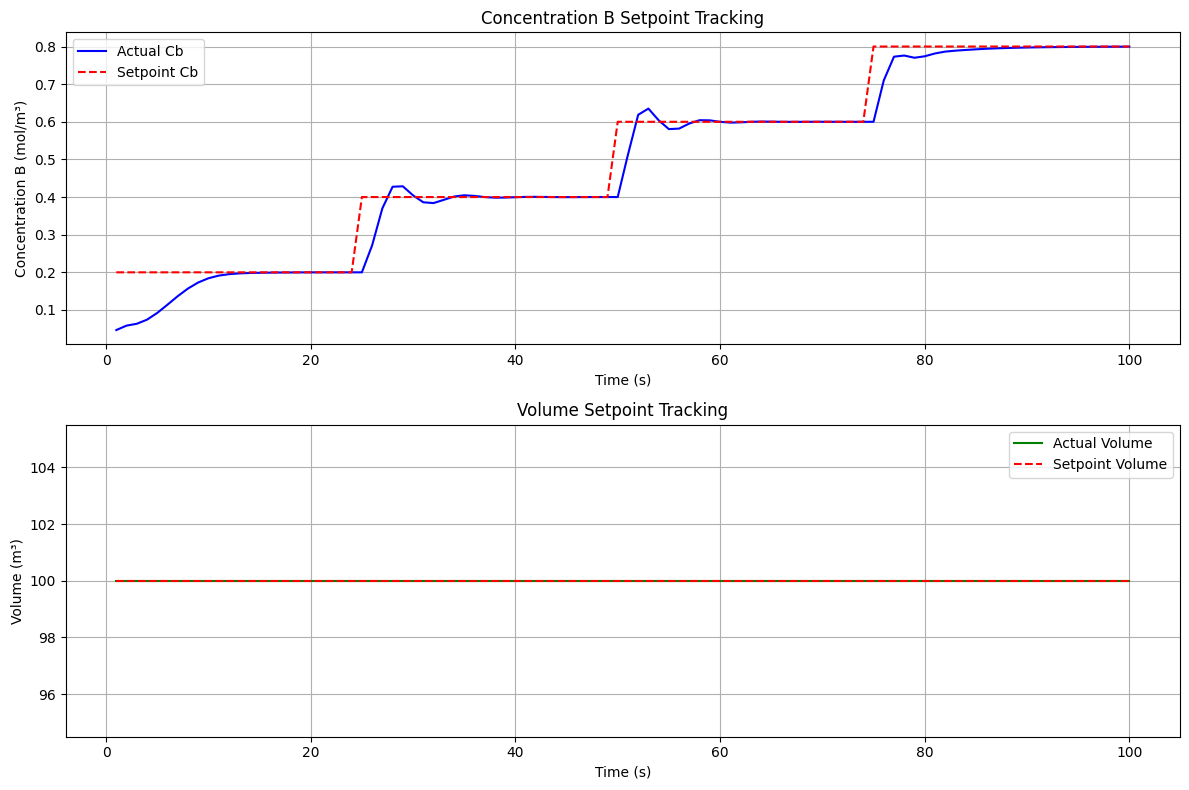

Simulation completed with setpoint tracking


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from CSTR_model_plus import CSTRRLEnv, PID_velocity

def main():
    # Create environment with setpoint tracking
    env = CSTRRLEnv(
        simulation_steps=100,
        dt = 1.0,
        uncertainty_level=0.0,
        noise_level=0.0,
        transport_delay_steps=0,
        actuator_delay_steps=0,
        enable_disturbances=False
    )

    # Define setpoints for tracking
    setpoints_Cb  = [0.2, 0.4, 0.6, 0.8]  # Concentration B setpoints
    setpoints_V   = [100, 100, 100, 100]  # Volume setpoints
    setpoint_durations = [25, 25, 25, 25] # 25 timesteps per setpoint

    # Reset environment with custom setpoints
    obs, _ = env.reset(options={
        'setpoints_Cb': setpoints_Cb,
        'setpoints_V': setpoints_V,
        'setpoint_durations': setpoint_durations
    })

    # Fixed PID gains for this example
    fixed_pid_gains = np.array([25., 0.7791, 0.0200, 0.7432, 0.7561, 0.0977])
    
    action = np.zeros(6) # Normalized action spaces [-1, 1]

    # Convert fixed gains to normalized action space
    action = 2.0 * (fixed_pid_gains - env.pid_lower) / (env.pid_upper - env.pid_lower) - 1.0

    # Run simulation with fixed controller
    done = False
    rewards = []
    cb_values = [] 
    cb_setpoints = []
    v_values = []
    v_setpoints = []
    time_values = []

    while not done:
        # Take a step with fixed PID controller
        obs, reward, done, _, info = env.step(action)

        # Store data for plotting
        rewards.append(reward)
        cb_values.append(info['true_state'][1])  # Concentration B
        cb_setpoints.append(info['setpoint_Cb'])
        v_values.append(info['true_state'][4])   # Volume
        v_setpoints.append(info['setpoint_V'])
        time_values.append(len(cb_values))
        
        # # Render the current state
        # env.render()

    # Plot results after simulation
    plt.figure(figsize=(12, 8))
    
    # Plot Concentration B
    plt.subplot(2, 1, 1)
    plt.plot(time_values, cb_values, 'b-', label='Actual Cb')
    plt.plot(time_values, cb_setpoints, 'r--', label='Setpoint Cb')
    plt.legend()
    plt.title('Concentration B Setpoint Tracking')
    plt.xlabel('Time (s)')
    plt.ylabel('Concentration B (mol/m³)')
    plt.grid(True)
    
    # Plot Volume
    plt.subplot(2, 1, 2)
    plt.plot(time_values, v_values, 'g-', label='Actual Volume')
    plt.plot(time_values, v_setpoints, 'r--', label='Setpoint Volume')
    plt.legend()
    plt.title('Volume Setpoint Tracking')
    plt.xlabel('Time (s)')
    plt.ylabel('Volume (m³)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Clean up
    env.close()

    print("Simulation completed with setpoint tracking")

if __name__ == "__main__":
    main()

## Section 2: PID Controllers Parameter Tuning

### Part 1: Static PID Gain Approach

This approach optimizes the static PID gains for the CSTR control system using differential evolution. The goal is to find optimal PID gains that minimize error when tracking a setpoint schedule. 

In [5]:
from static_pid_gain import StaticPIDOptimizer, run_optimization

if __name__ == "__main__":
    from CSTR_model_plus import CSTRRLEnv

    # Create environment with minimal noise/disturbance/noise for optimization
    env = CSTRRLEnv(
        simulation_steps=25*5,
        dt=1.0,
        uncertainty_level=0.0,     # No uncertainty
        noise_level=0.0,           # No measurement noise
        actuator_delay_steps=0,    # No actuator delay
        transport_delay_steps=0,   # No transport delay
        enable_disturbances=False  # No disturbances
    )

    # Run optimization
    optimal_gains = run_optimization(env, maxiter=30, popsize=15)

    print("Optimization complete.")

Starting optimization with 30 iterations and population size 15
differential_evolution step 1: f(x)= 0.2704660026152467
differential_evolution step 2: f(x)= 0.2704660026152467
differential_evolution step 3: f(x)= 0.2704660026152467
differential_evolution step 4: f(x)= 0.2668539916176404
differential_evolution step 5: f(x)= 0.2668539916176404
differential_evolution step 6: f(x)= 0.2668539916176404
differential_evolution step 7: f(x)= 0.2668539916176404
differential_evolution step 8: f(x)= 0.23560541783271693
differential_evolution step 9: f(x)= 0.23560541783271693
differential_evolution step 10: f(x)= 0.23560541783271693
differential_evolution step 11: f(x)= 0.23560541783271693
differential_evolution step 12: f(x)= 0.23560541783271693
differential_evolution step 13: f(x)= 0.23560541783271693
differential_evolution step 14: f(x)= 0.23560541783271693
differential_evolution step 15: f(x)= 0.23383905440634237
differential_evolution step 16: f(x)= 0.23383905440634237
differential_evolution s

Loaded data from ./results/optimal_pid_gains.npy:
 [2.50000000e+01 7.32644787e-01 2.00000000e-02 3.53409552e-01
 2.58712863e-01 2.72371291e-01]


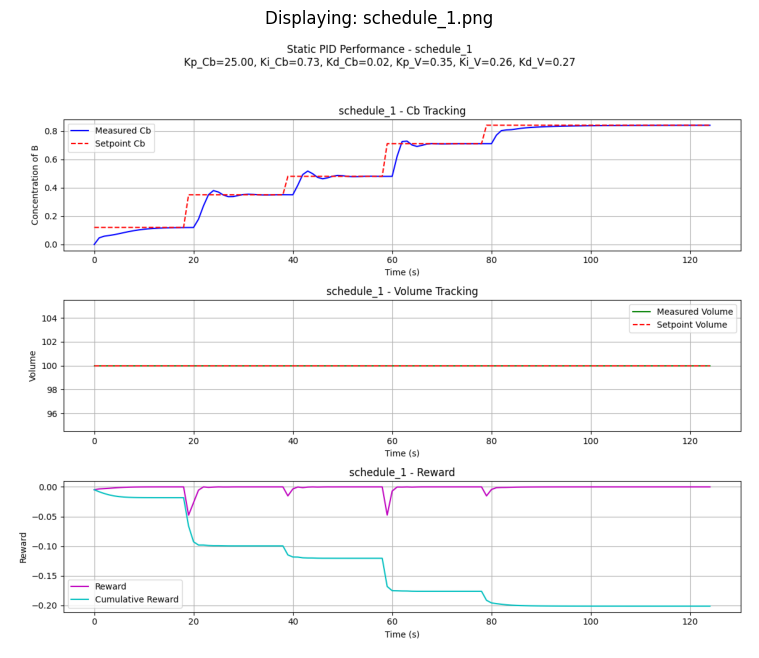

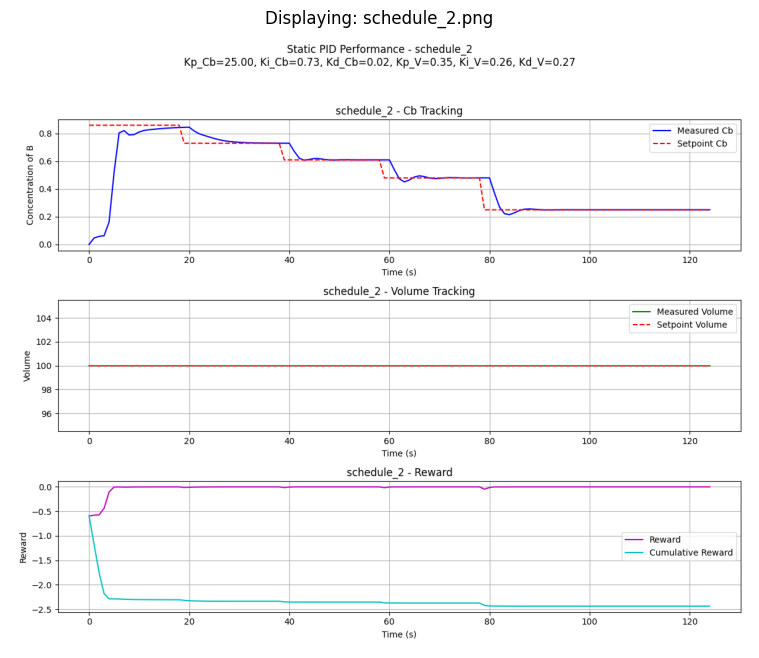

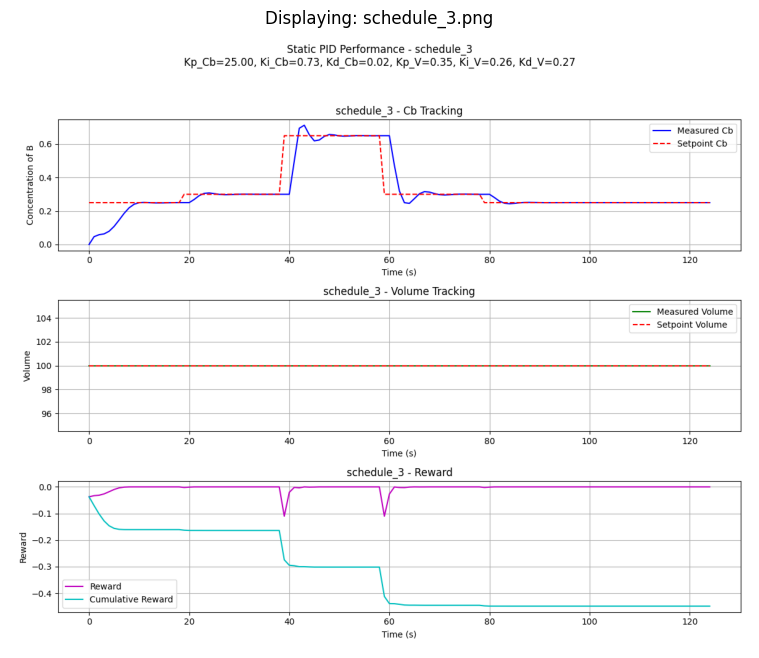

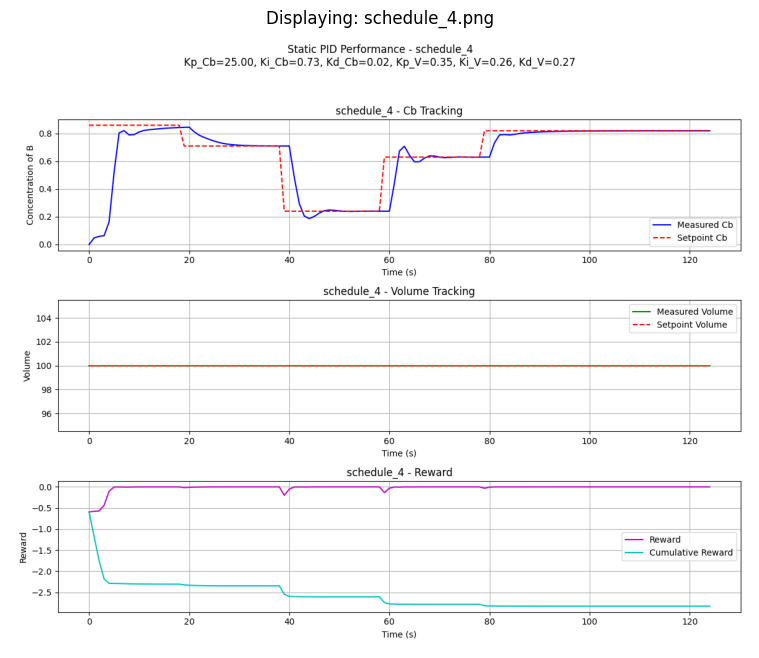

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_npy_file(npy_path):
    if os.path.exists(npy_path):
        data = np.load(npy_path)
        print(f"Loaded data from {npy_path}:\n", data)
        return data
    else:
        print(f"Error: File {npy_path} not found")
        return None
    
def display_png_file(png_path):
    if os.path.exists(png_path):
        img = plt.imread(png_path)
        plt.figure(figsize=(12,8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Displaying: {os.path.basename(png_path)}")
        plt.show()
    else:
        print(f"Eror: File {png_path} not found.")

if __name__ == "__main__":
    npy_file_path = "./results/optimal_pid_gains.npy"
    load_npy_file(npy_file_path)
    for i in range(4):
        png_file_path = f"./results/plots/schedule_{i+1}.png"
        display_png_file(png_file_path) 
        


### Part 2: Adaptive PID Control (Conventional Approach)



## Section 3. Reinforcement Learning for Dynamic Tuning of PID Controllers

### Part 0: Historical (Simulation) Data Generation

Key Assumptions:

1. In real-world chemical process industries, before a plant is built, extensive modeling, design, and simulations are conducted

Conclusion from 1: If the plant is well-designed and commisioned, then a reasonably accurate model exists. However, uncertainties and disturbances (e.g., catalyst deactivation, equipment aging) always exist, which is why adaptive control and RL-based tuning can be useful.

2. If a reliable model exists, we can use it to simulate vast amounts of data before applying RL in real plant. Advantages: 
    * Safe exploration -- RL does not need to interact with the real plant, avoiding unsafe operations. 
    * Large-scale data generation -- We can simulate disturbances, different setpoints, and failure modes to cover a wide range of scenarios.
    * Better Generalization -- The RL agent can learn from highly diverse training data rather than being constrained by limited real-world trials.
    * Efficient Deployment -- Once trained on simulated data, the RL-based PID tuning model can be fine-tuned online with minimal interaction. 


Additional Comments on the offline dataset

* Essential Data for Offline RL:
    * Transitions: (state, action, reward, next_state, done) tuples
    * Metadata: Actual PID gains, setpoints, and any relevant simulation parameters
    * Coverage: The dataset should span nominal operating conditions, disturbances, and various setpoint transitions to train an RL agent robustly

* Plots:
    * Episode Reward Curves: To visualize performance over time
    * Action Distribtions: To verify that the exploration strategy covers a wide range of actions
    * State vs. Setpoint Trajectories: To ensure that the data reflects diverse tracking behaviors
    * Summary Statics: Such as means and variances of key variables to provide an overall view of data diversity

* Range of Spectrum:
    * Dataset includes episodes under normal operation, under disturbances, and with different setpoint profiles (increasing, decreasing, peak, valley, constant). => This helps the offline RL algorithm learn a robust policy that generalizes across operating conditions


In [1]:
from gen_sim_data import generate_diverse_dataset, DataGenerator

if __name__ == "__main__":
    from CSTR_model_plus import CSTRRLEnv
    
    # Create environment with realistic conditions
    env = CSTRRLEnv(
        simulation_steps=120,
        dt=1.0,
        uncertainty_level=0.00,     # Add some uncertainty for realism
        noise_level=0.00,           # Add some noise for realism
        actuator_delay_steps=0,     # Add realistic delays
        transport_delay_steps=0,
        enable_disturbances=False   # Enable disturbances for robustness
    )
    
    # Generate dataset with default parameters
    dataset = generate_diverse_dataset(env, n_episodes=50, save_dir="./offline_data", seed=42)
    
    print("Dataset generation complete.")

Generating diverse dataset with 50 total episodes
Generating 25 episodes with 'static_pid' strategy


100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


Generated dataset with 3000 transitions from 25 episodes
Generating 25 episodes with 'decaying' strategy


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Generated dataset with 3000 transitions from 25 episodes
Combined 2 datasets with a total of 6000 transitions
Dataset contains 6000 transitions from 50 episodes
Reward statistics:
  Mean: -0.0823
  Std: 0.1053
  Min: -0.5216
  Max: -0.0000
Action statistics:
  Action 0 - Mean: 25.0000, Std: 0.5337
  Action 1 - Mean: 0.7458, Std: 0.5187
  Action 2 - Mean: 0.0165, Std: 0.5210
  Action 3 - Mean: 0.3464, Std: 0.5213
  Action 4 - Mean: 0.2512, Std: 0.5352
  Action 5 - Mean: 0.2717, Std: 0.5190
PID gains statistics:
  Kp_Cb - Mean: 384.9998, Std: 8.0059
  Ki_Cb - Mean: 17.4582, Std: 5.1872
  Kd_Cb - Mean: 5.0922, Std: 2.6000
  Kp_V - Mean: 0.6732, Std: 0.2606
  Ki_V - Mean: 1.2512, Std: 0.5352
  Kd_V - Mean: 0.6395, Std: 0.2569
Unique Cb setpoints: [0.20921305 0.36217808 0.51852999 0.51906094 0.6        0.61239576
 0.64259298 0.65       0.7        0.72637915 0.75       0.75764926
 0.76550001 0.77870924 0.8       ]
Dataset saved to ./offline_data/cstr_diverse_dataset.pkl
Dataset generation co

In [2]:
import pickle

def print_dataset(file_path):
    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)
    
    for key, value in dataset.items():
        print(f"{key}: {value}")

# Specify the file path
file_path = '/home/jzhao/work/nonlinear-multi-loop-CSTR-for-RL/offline_data/cstr_diverse_dataset.pkl'

# Print the dataset
print_dataset(file_path)

states: [[0.00000000e+00 3.25000000e+02 1.00000000e+02 ... 1.00000000e+02
  6.00000000e-01 1.00000000e+02]
 [0.00000000e+00 3.25000000e+02 1.00000000e+02 ... 1.00000000e+02
  6.00000000e-01 1.00000000e+02]
 [4.66206757e-02 3.17018712e+02 1.00000000e+02 ... 1.00000000e+02
  6.00000000e-01 1.00000000e+02]
 ...
 [7.62241621e-01 4.22668361e+02 1.00000000e+02 ... 1.00000000e+02
  8.00000000e-01 1.00000000e+02]
 [3.66082240e-01 3.15119888e+02 1.00000000e+02 ... 1.00000000e+02
  8.00000000e-01 1.00000000e+02]
 [7.62241621e-01 4.22668361e+02 1.00000000e+02 ... 1.00000000e+02
  8.00000000e-01 1.00000000e+02]]
actions: [[ 2.51621218e+01  8.02646823e-01  1.06871072e-01  3.22762614e-01
   4.71530695e-01  2.13829246e-01]
 [ 2.47654755e+01  6.44995357e-01 -1.63224271e-02  5.77158693e-01
   2.10041390e-01  2.77104723e-01]
 [ 2.52093208e+01  9.98122607e-01 -6.54275896e-02  3.76307980e-01
   1.90624169e-01  1.07129911e-01]
 ...
 [ 2.49970163e+01  7.98327536e-01  2.04982132e-02  3.90597825e-01
   2.3252

### Part 1: Particle Swarm Optimizer (PSO) + Control-Informed RL (CIRL)

* The Particle Swarm Optimization (PSO) algorithm is an optimization technique inspured by the collective behavior in flocks of birds or schools of fish. As an evolutionary algorithm, PSO mimics the way individuals (particles) in a group evolve their positions to collectively find an optimal solution. 

    In PSO:
    * Each particle represents a potential solution to the problem
    * Particles move through the solution space, guided by their own best-known position and the best-known position of their neighbors or the entire swarm
    * Over time, particle "evolve" by updating their positions and velocities, balancing exploration (searching new areas) and exploitation (focusing on promising areas).

This evolutionary process shares similarities with other EAs like genetic algorithms, in that it involves iteration and optimization based on a population of solutions, but it doesn't involve genetic operators like crossover or mutation. Instead, it focuses on social interaction and learning.

**CIRL Rollout**:

**Input:** Policy Parameters $ \theta $, Number of simulation timesteps $ n_s $, Discrete time environment $ f $  
**Output:** Cumulative Reward $ R $

1. $ s \gets s_0 $  # Reset observation to initial state  
2. $ R \gets 0 $  # Initialize cumulative reward  
3. **for** $ t = 0 $ **to** $ n_s - 1 $:  
    1. $ K_{p,t}, \tau_{i,t}, \tau_{d,t} \gets \pi_\theta(s_t) $  # Get current PID gains from policy  
    2. $ u_t \gets PID(K_{p,t}, \tau_{i,t}, \tau_{d,t}, e_t, e_{t-1}, e_{t-2}) $  # Use PID controller to output control input  
    3. $ x_{t+1}, r_t \gets f(u_t, x_t) $  # Take one timestep in the environment  
    4. $ s_{t+1} \gets [x_{t+1}, x_t, x^*_{t+1}] $  # Update observation vector  
    5. $ R \gets R + r_t $  
4. **return** $ R $  # Return cumulative reward



Loaded dataset from /home/jzhao/work/nonlinear-multi-loop-CSTR-for-RL/offline_data/cstr_diverse_dataset.pkl with 6000 transitions
Starting supervised learning phase...
Loaded 6000 transitions into replay buffer (capacity: 7000)


Epoch 50/50 | Loss: 96.981346: 100%|██████████| 50/50 [00:04<00:00, 12.23it/s]


Supervised learning completed. Final model saved to ./results/CIRL/models/cirl_policy_supervised.pt


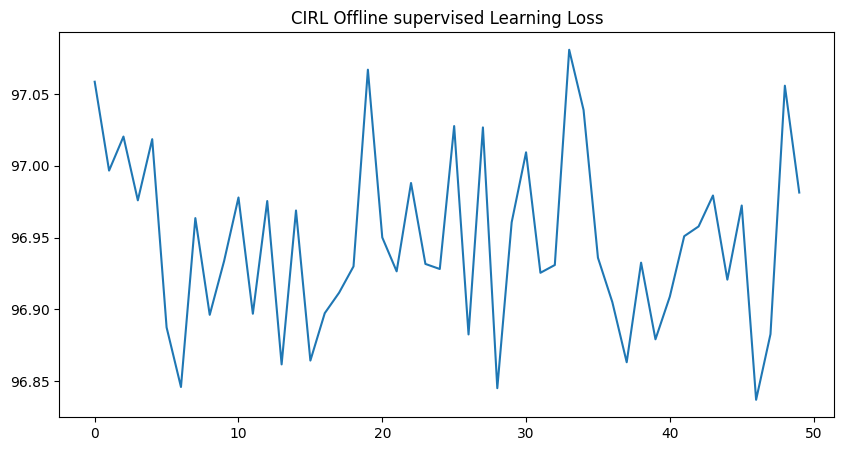

Starting PSO optimization phase...


  0%|          | 0/50 [00:00<?, ?it/s]

  Schedule 1: -18.0214
  Schedule 2: -22.9881
  Schedule 3: -17.7703
  Schedule 4: -23.8243


Iteration 10/50 | Best: -1.4397 | Mean: -7.7270:  20%|██        | 10/50 [01:45<06:38,  9.96s/it]

  Schedule 1: -8.2058
  Schedule 2: -6.9128
  Schedule 3: -6.8132
  Schedule 4: -9.1753


Iteration 20/50 | Best: -1.4363 | Mean: -8.5650:  40%|████      | 20/50 [03:20<04:51,  9.71s/it]

  Schedule 1: -1.0550
  Schedule 2: -1.8047
  Schedule 3: -1.1299
  Schedule 4: -1.8739


Iteration 30/50 | Best: -1.4175 | Mean: -7.5699:  60%|██████    | 30/50 [04:57<03:14,  9.71s/it]

  Schedule 1: -9.8161
  Schedule 2: -7.0174
  Schedule 3: -8.5326
  Schedule 4: -9.2799


Iteration 40/50 | Best: -1.4175 | Mean: -6.1490:  80%|████████  | 40/50 [06:35<01:38,  9.80s/it]

  Schedule 1: -10.4878
  Schedule 2: -7.0545
  Schedule 3: -8.3023
  Schedule 4: -9.3171


Iteration 50/50 | Best: -1.3883 | Mean: -5.5237: 100%|██████████| 50/50 [08:11<00:00,  9.83s/it]

PSO optimization completed. Final model saved to ./results/CIRL/models/cirl_policy_pso.pt
Best score: -1.3883


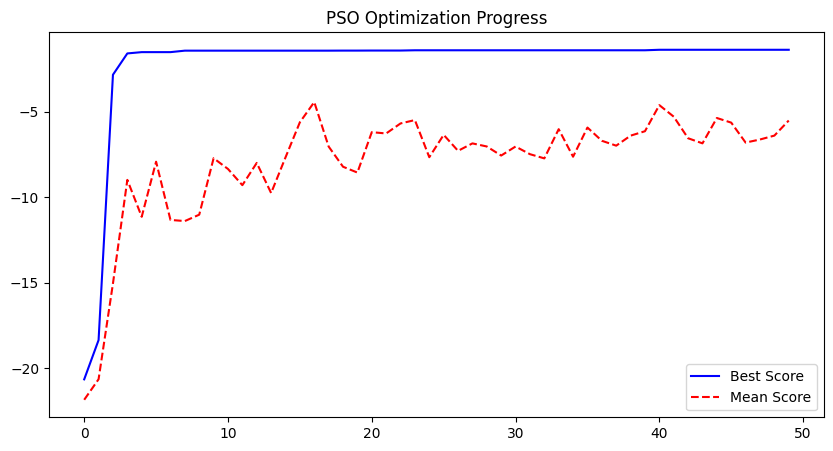


Evaluating on Increasing schedule: [0.65, 0.7, 0.75]
  Episode 1: Reward = -1.19, MSE Cb = 0.008838, MSE V = 0.000000
  Episode 2: Reward = -1.19, MSE Cb = 0.008838, MSE V = 0.000000
  Episode 3: Reward = -1.19, MSE Cb = 0.008838, MSE V = 0.000000
  Schedule Increasing results:
    Mean reward: -1.19
    Mean MSE Cb: 0.008838
    Mean MSE V: 0.000000

Evaluating on Decreasing schedule: [0.75, 0.7, 0.65]
  Episode 1: Reward = -1.46, MSE Cb = 0.010845, MSE V = 0.000000
  Episode 2: Reward = -1.46, MSE Cb = 0.010845, MSE V = 0.000000
  Episode 3: Reward = -1.46, MSE Cb = 0.010845, MSE V = 0.000000
  Schedule Decreasing results:
    Mean reward: -1.46
    Mean MSE Cb: 0.010845
    Mean MSE V: 0.000000

Evaluating on Peak schedule: [0.7, 0.75, 0.7]
  Episode 1: Reward = -1.33, MSE Cb = 0.009818, MSE V = 0.000000
  Episode 2: Reward = -1.33, MSE Cb = 0.009818, MSE V = 0.000000
  Episode 3: Reward = -1.33, MSE Cb = 0.009818, MSE V = 0.000000
  Schedule Peak results:
    Mean reward: -1.33
  

In [1]:
from Train_PSO_CIRL import CIRLTrainer, set_seed
from CSTR_model_plus import CSTRRLEnv
import matplotlib.pyplot as plt


if __name__ == "__main__":
    # Create environment with minimal noise/disturbance
    env = CSTRRLEnv(
        simulation_steps=150,
        dt=1.0,
        uncertainty_level=0.0,
        noise_level=0.0,
        actuator_delay_steps=0,
        transport_delay_steps=0,
        enable_disturbances=False
    )

    # Set random seed for reproducibility
    set_seed(42)

    # Create trainer
    trainer = CIRLTrainer(env, save_dir="./results/CIRL")

    # Train policy
    # Load dataset
    dataset = trainer.load_offline_dataset(
        file_path="/home/jzhao/work/nonlinear-multi-loop-CSTR-for-RL/offline_data/cstr_diverse_dataset.pkl"
    )

    # Create policy network
    policy = trainer.create_policy_network(hidden_dims=[128,128])

    # Supervised learning phase
    supervised_stats = trainer.train_supervised(
        policy=policy,
        dataset=dataset,
        n_epochs=50,
        batch_size=256,
        learning_rate=1e-3,
        weight_decay=1e-4,
        save_interval=25,
        verbose=True
    )

    # Plot supervised learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(supervised_stats['epochs'], supervised_stats['mean_losses'])
    plt.title("CIRL Offline supervised Learning Loss")
    plt.show()

    # PSO optimization
    best_policy, pso_history = trainer.train_pso(
        policy_template=policy,
        n_iterations=50,
        num_particles=20 # more particles = longer training time
    )

    # Plot PSO learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(pso_history['iterations'], pso_history['best_scores'], 'b-', label='Best Score')
    plt.plot(pso_history['iterations'], pso_history['mean_scores'], 'r--', label='Mean Score')
    plt.title("PSO Optimization Progress")
    plt.legend()
    plt.show()

    # Evaluate the trained policy
    eval_results = trainer.evaluate_policy(
        policy=best_policy,
        n_episodes=3,
        render=False
    )

Evaluating on Increasing schedule: [0.12, 0.35, 0.48, 0.71, 0.84]
  Reward: -0.22, MSE Cb: 0.001657, MSE V: 0.000000
Evaluating on Decreasing schedule: [0.86, 0.73, 0.61, 0.48, 0.25]
  Reward: -2.48, MSE Cb: 0.018399, MSE V: 0.000000
Evaluating on Peak schedule: [0.25, 0.3, 0.65, 0.3, 0.25]
  Reward: -0.47, MSE Cb: 0.003461, MSE V: 0.000000
Evaluating on Valley schedule: [0.86, 0.71, 0.24, 0.63, 0.82]


  Reward: -2.94, MSE Cb: 0.021752, MSE V: 0.000000


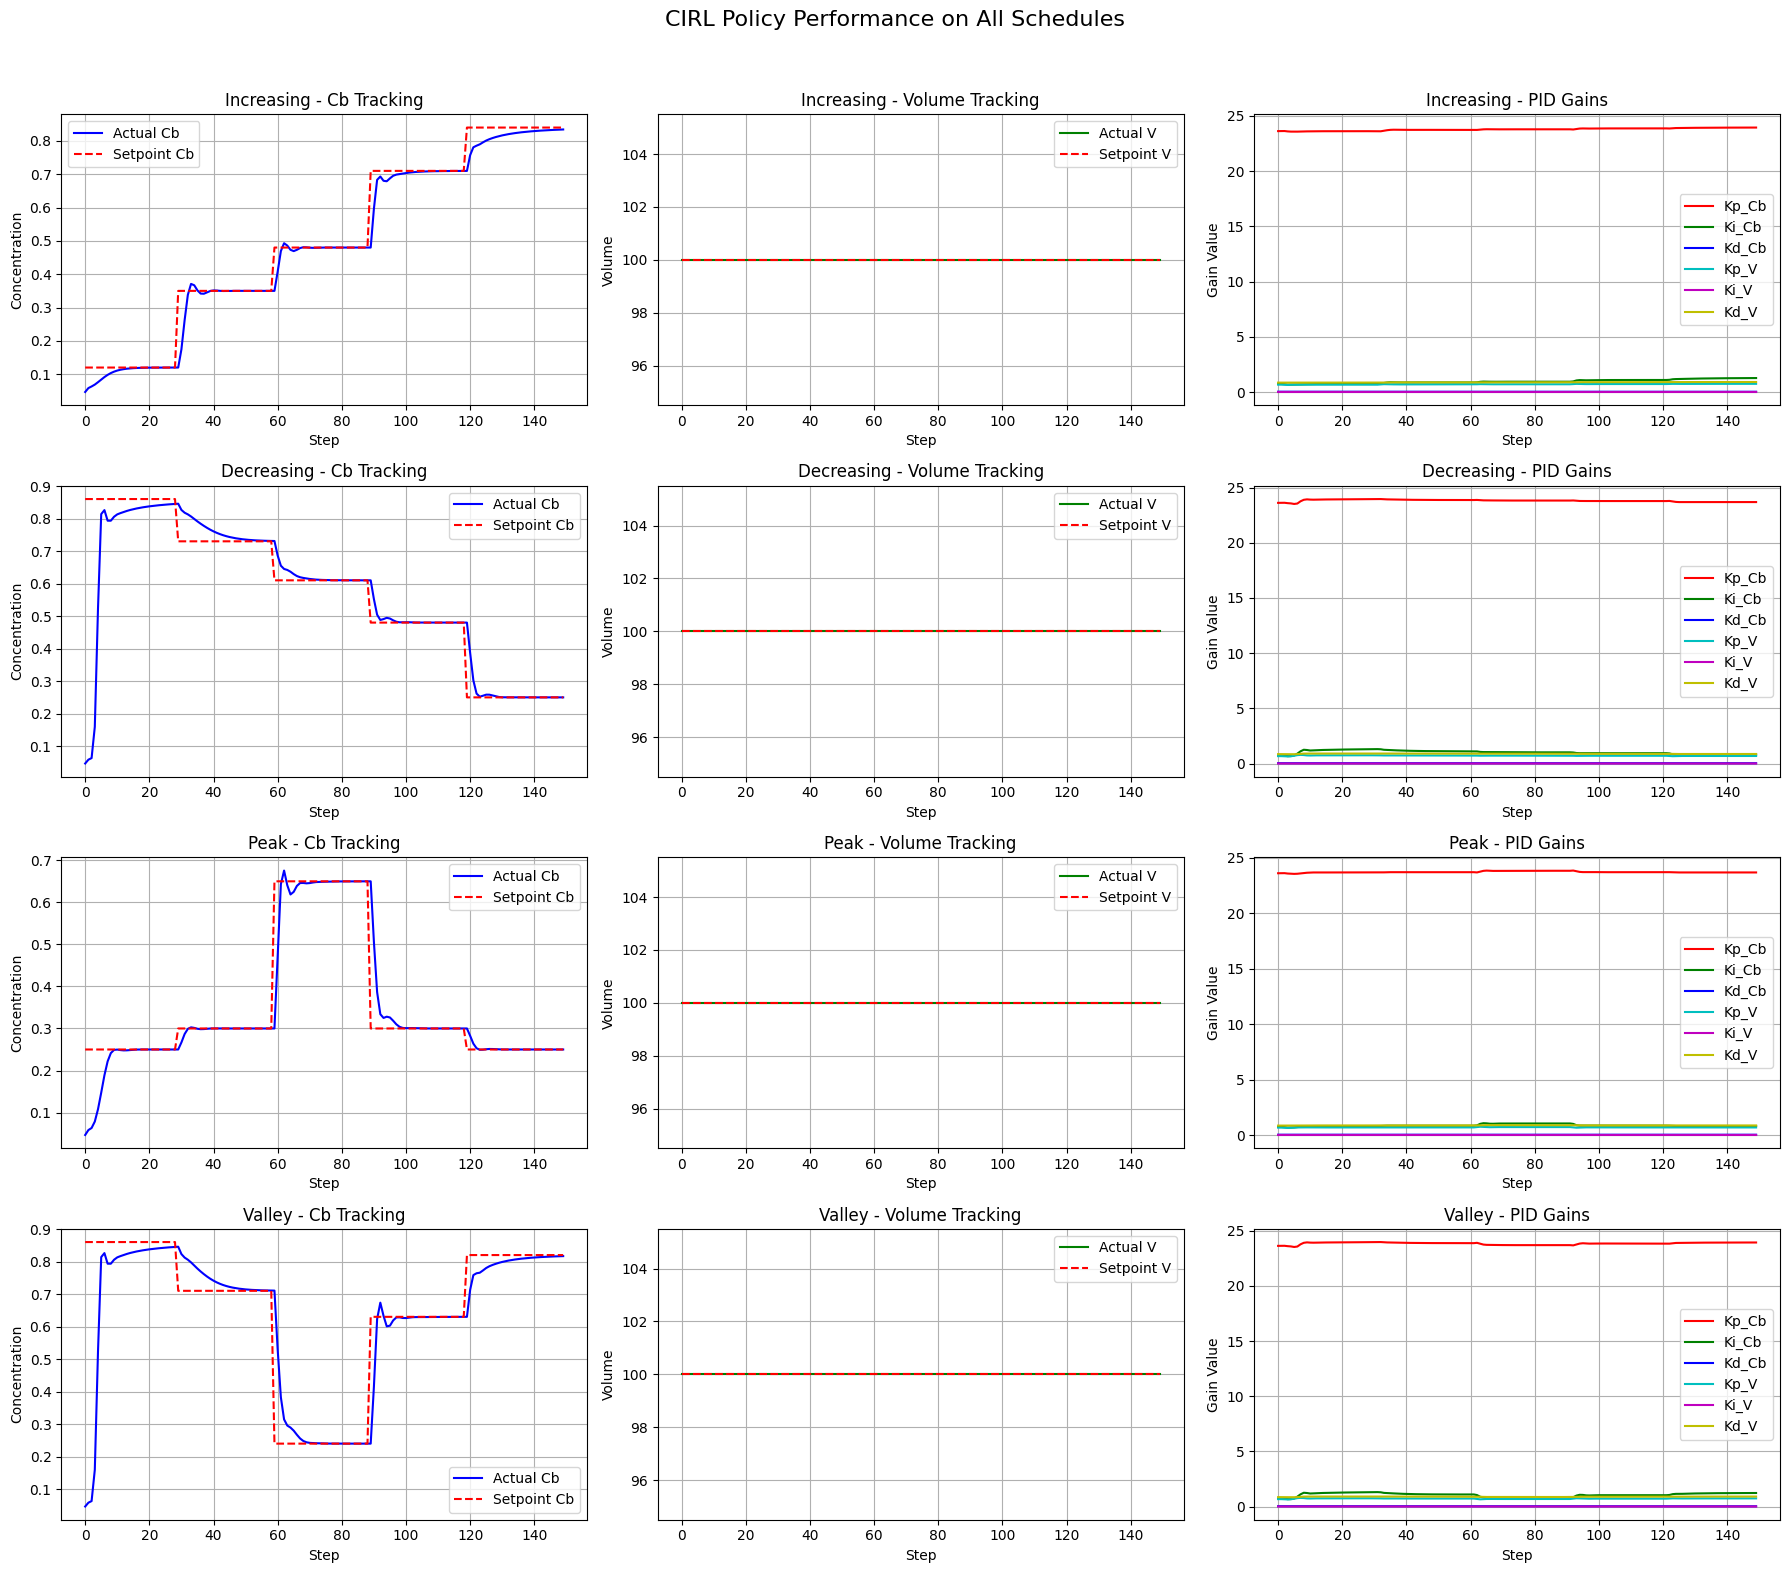

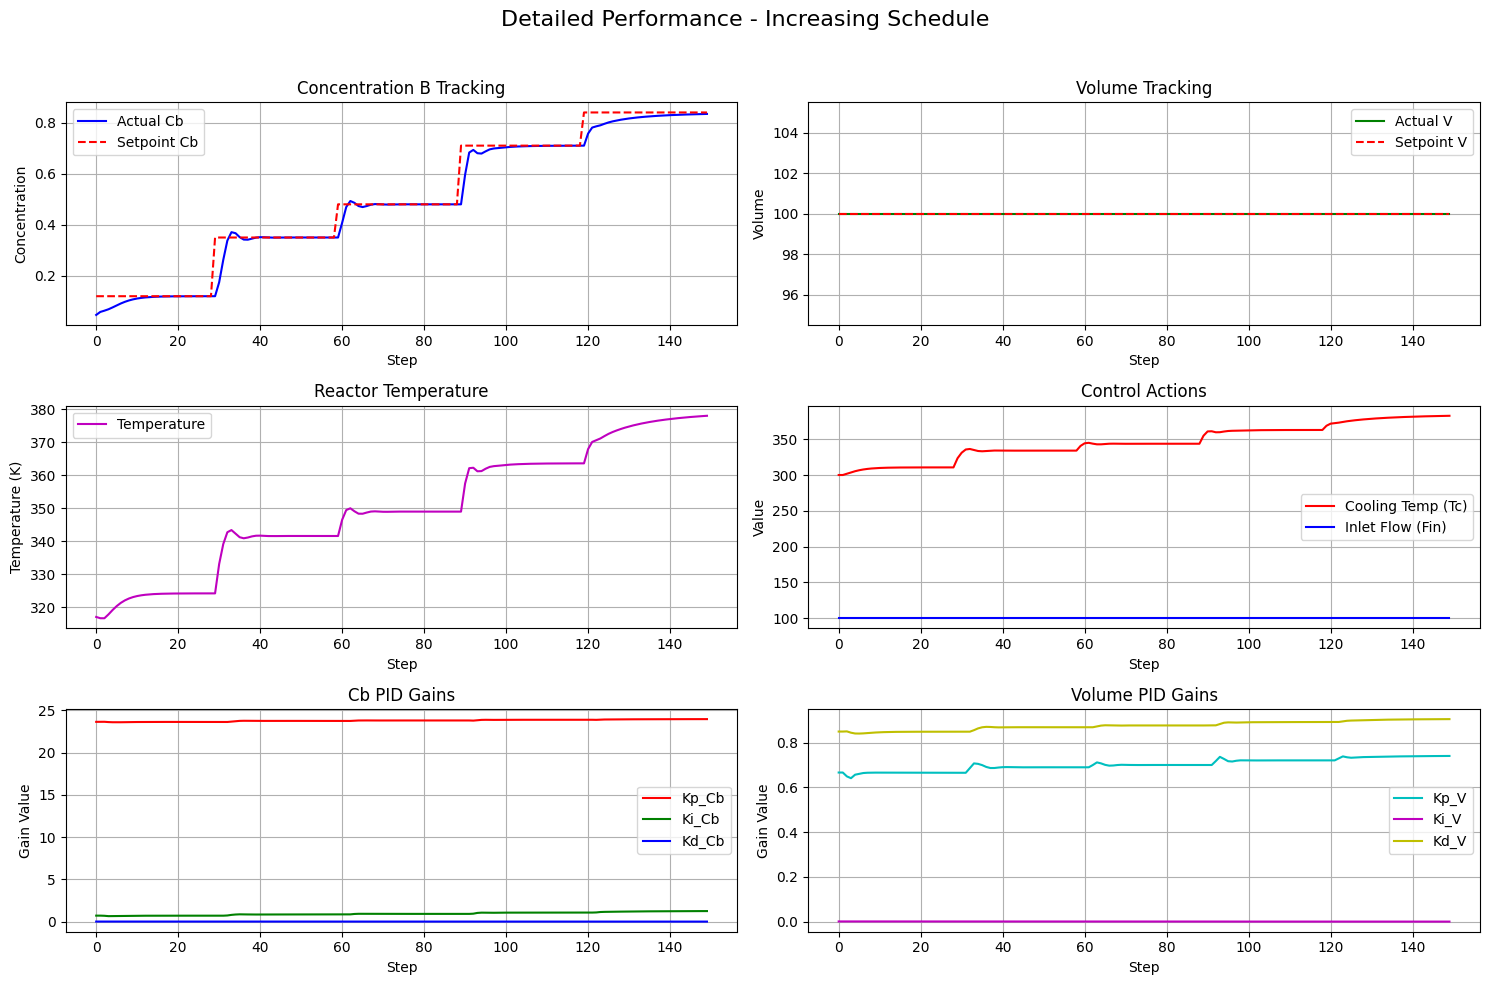

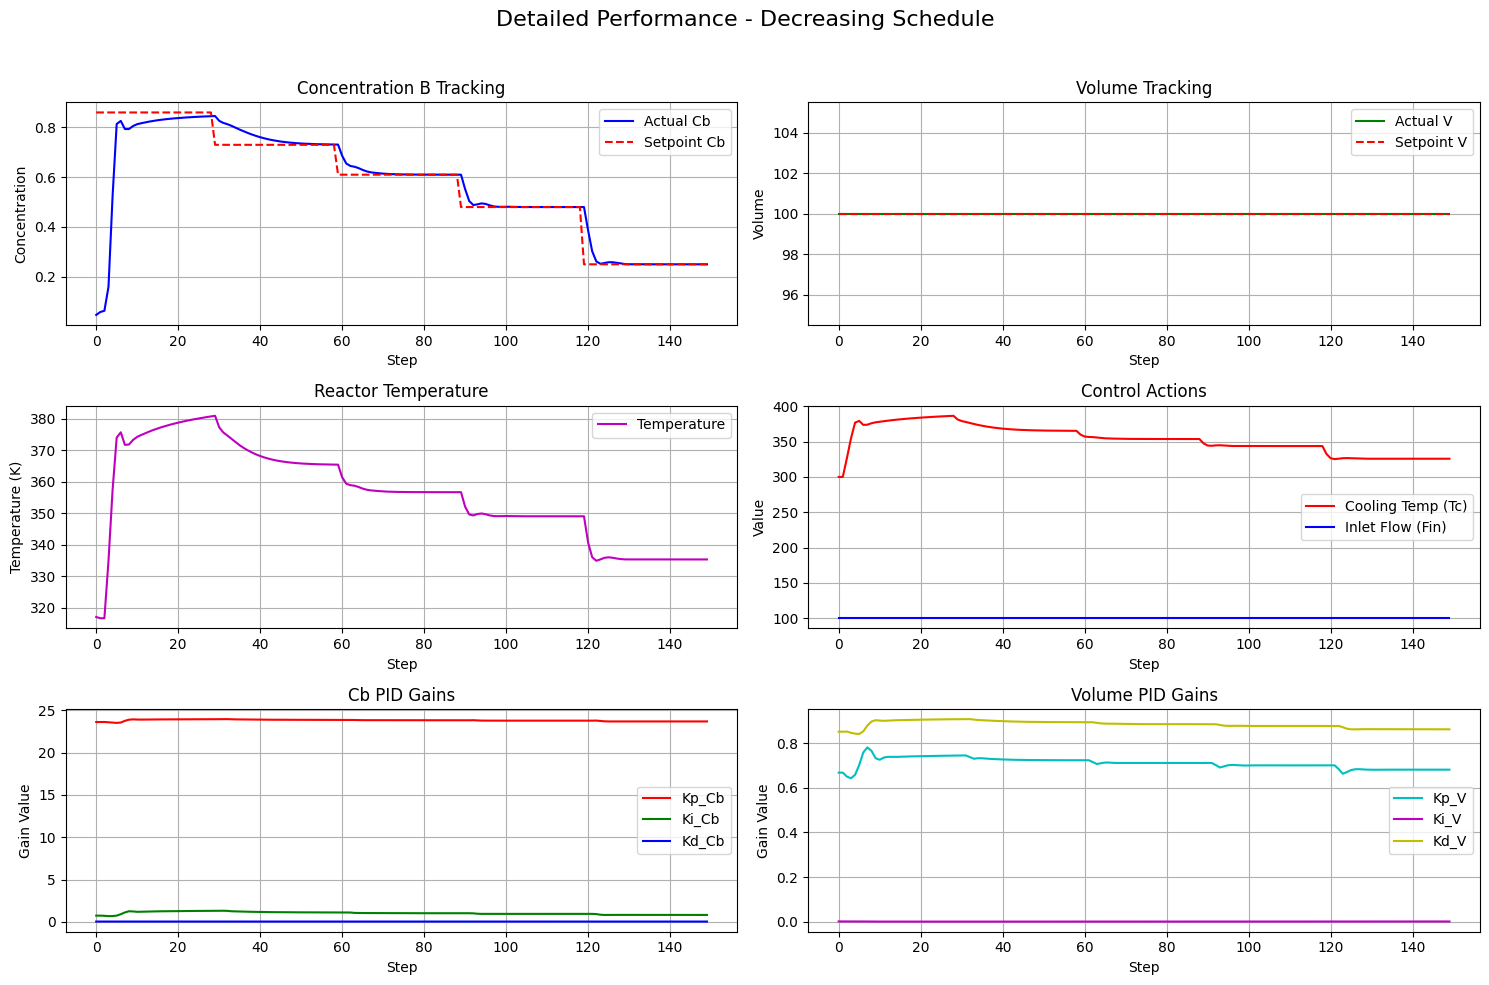

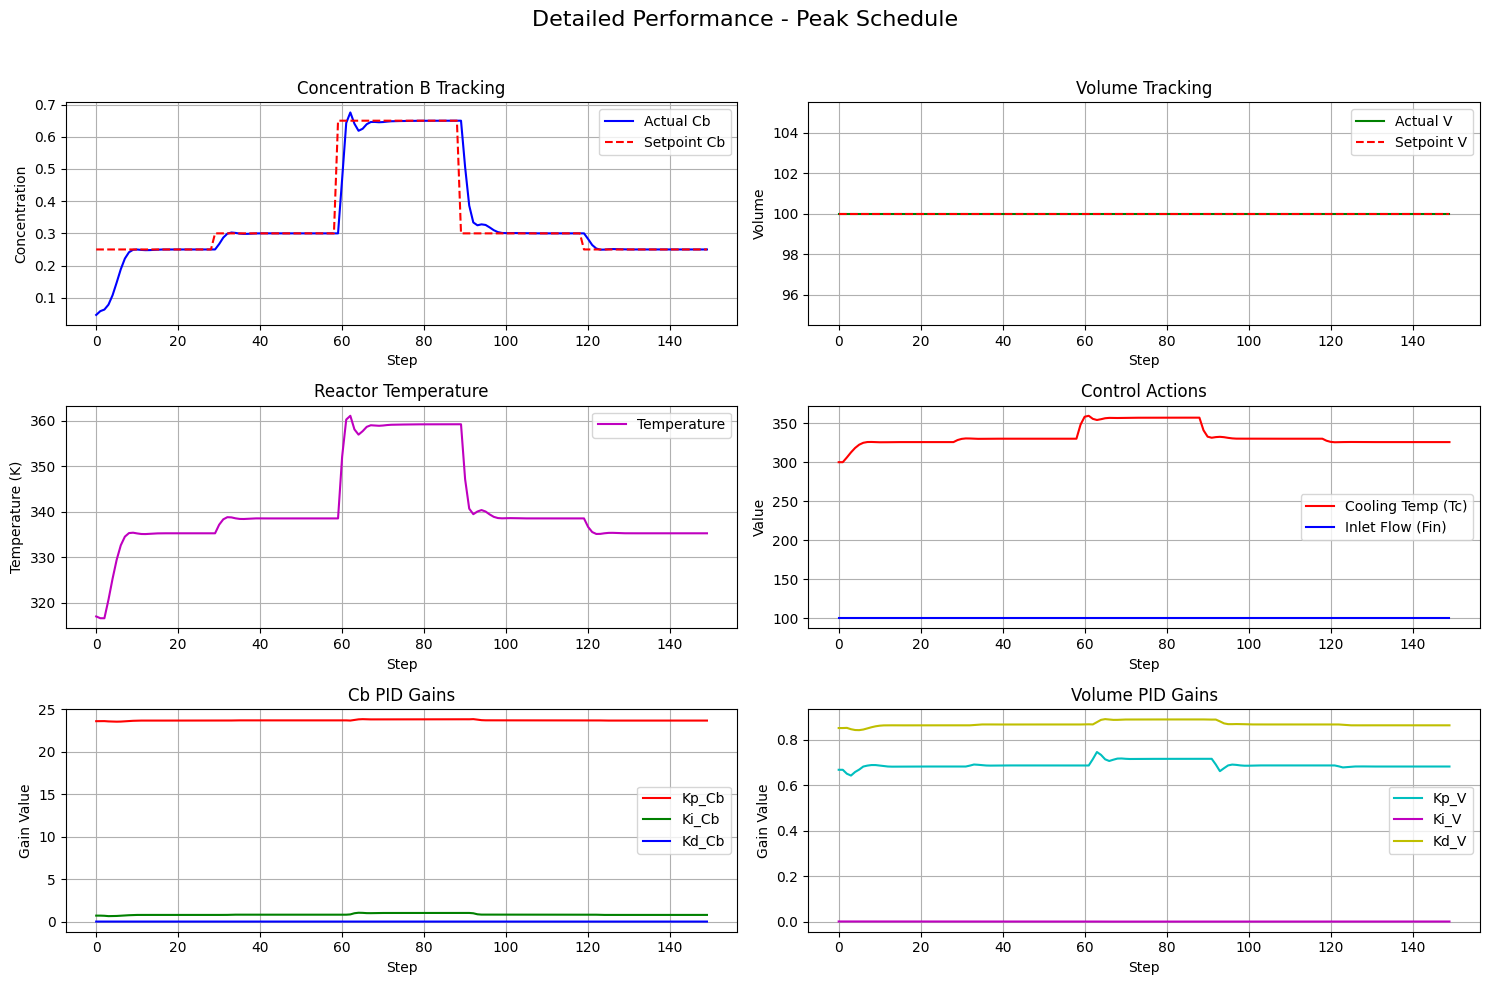

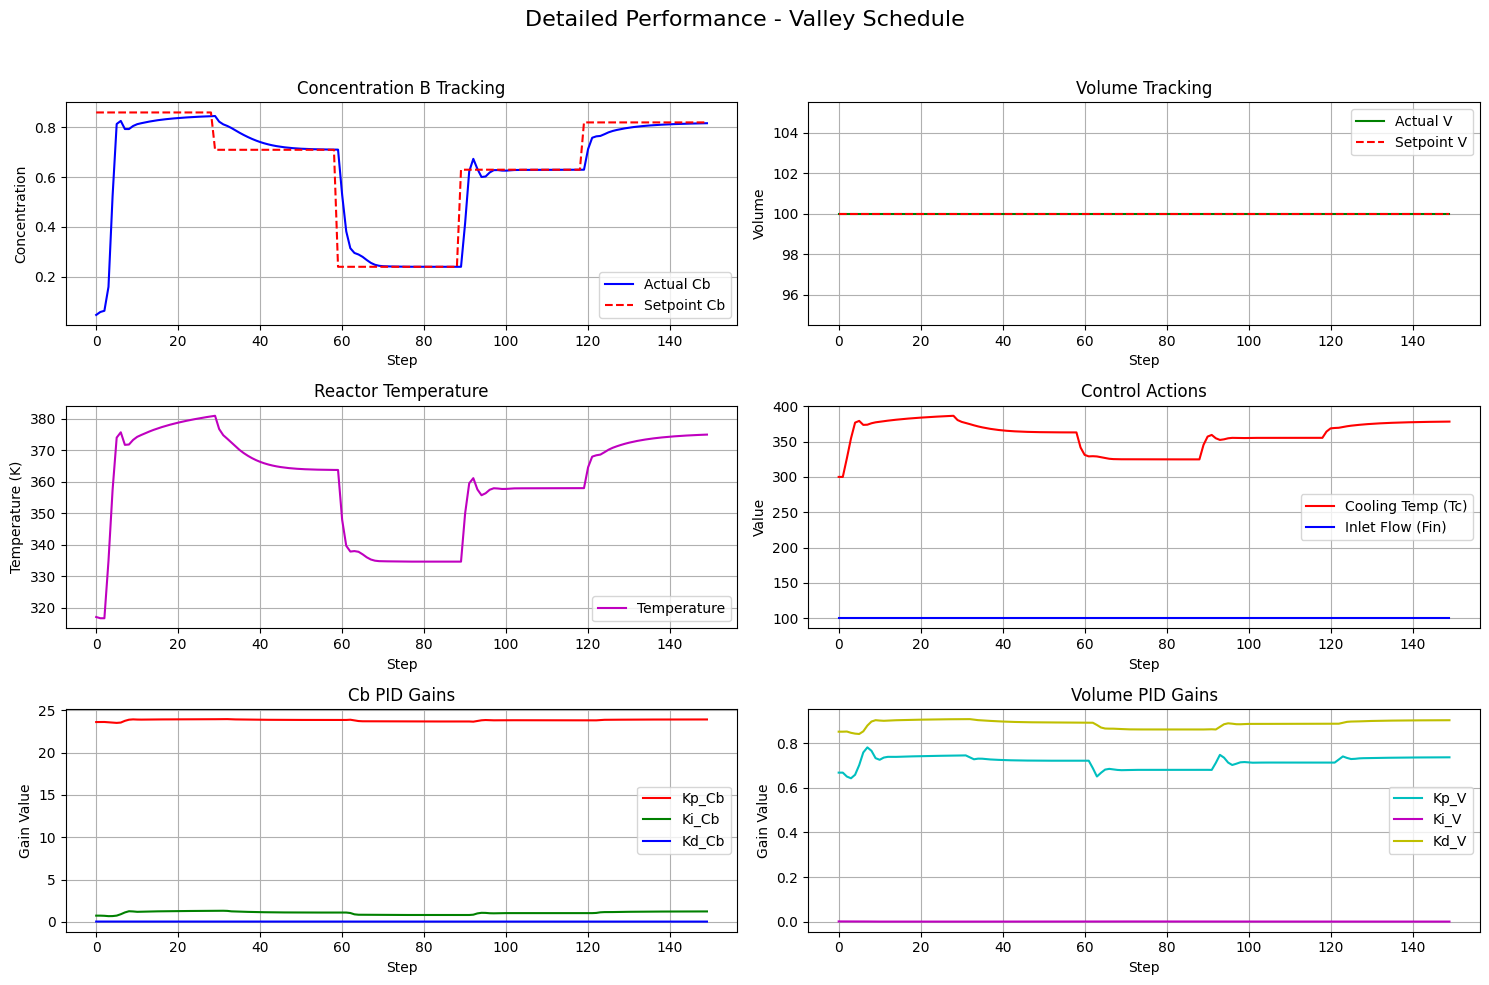

In [3]:
from cirl_visualization import plot_all_schedules
from cirl_policy_network import CIRLPolicyNetwork
import torch
if __name__ == "__main__":
    # Create environment
    env = CSTRRLEnv(
        simulation_steps=150,
        dt=1.0,
        uncertainty_level=0.0,
        noise_level=0.0,
        actuator_delay_steps=0,
        transport_delay_steps=0,
        enable_disturbances=False
    )
    
    # Load trained policy
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy = CIRLPolicyNetwork(state_dim=env.observation_space.shape[0], hidden_dims=[64, 64]).to(device)
    policy.load("./results/CIRL/models/cirl_policy_final.pt")
    
    # Run evaluation and plotting
    results = plot_all_schedules(policy, env, save_dir="./results/CIRL/test_plots")



Analyzing PID gains for Increasing schedule: [0.12, 0.35, 0.48, 0.71, 0.84]
Analyzing PID gains for Decreasing schedule: [0.86, 0.73, 0.61, 0.48, 0.25]


Analyzing PID gains for Peak schedule: [0.25, 0.3, 0.65, 0.3, 0.25]
Analyzing PID gains for Valley schedule: [0.86, 0.71, 0.24, 0.63, 0.82]


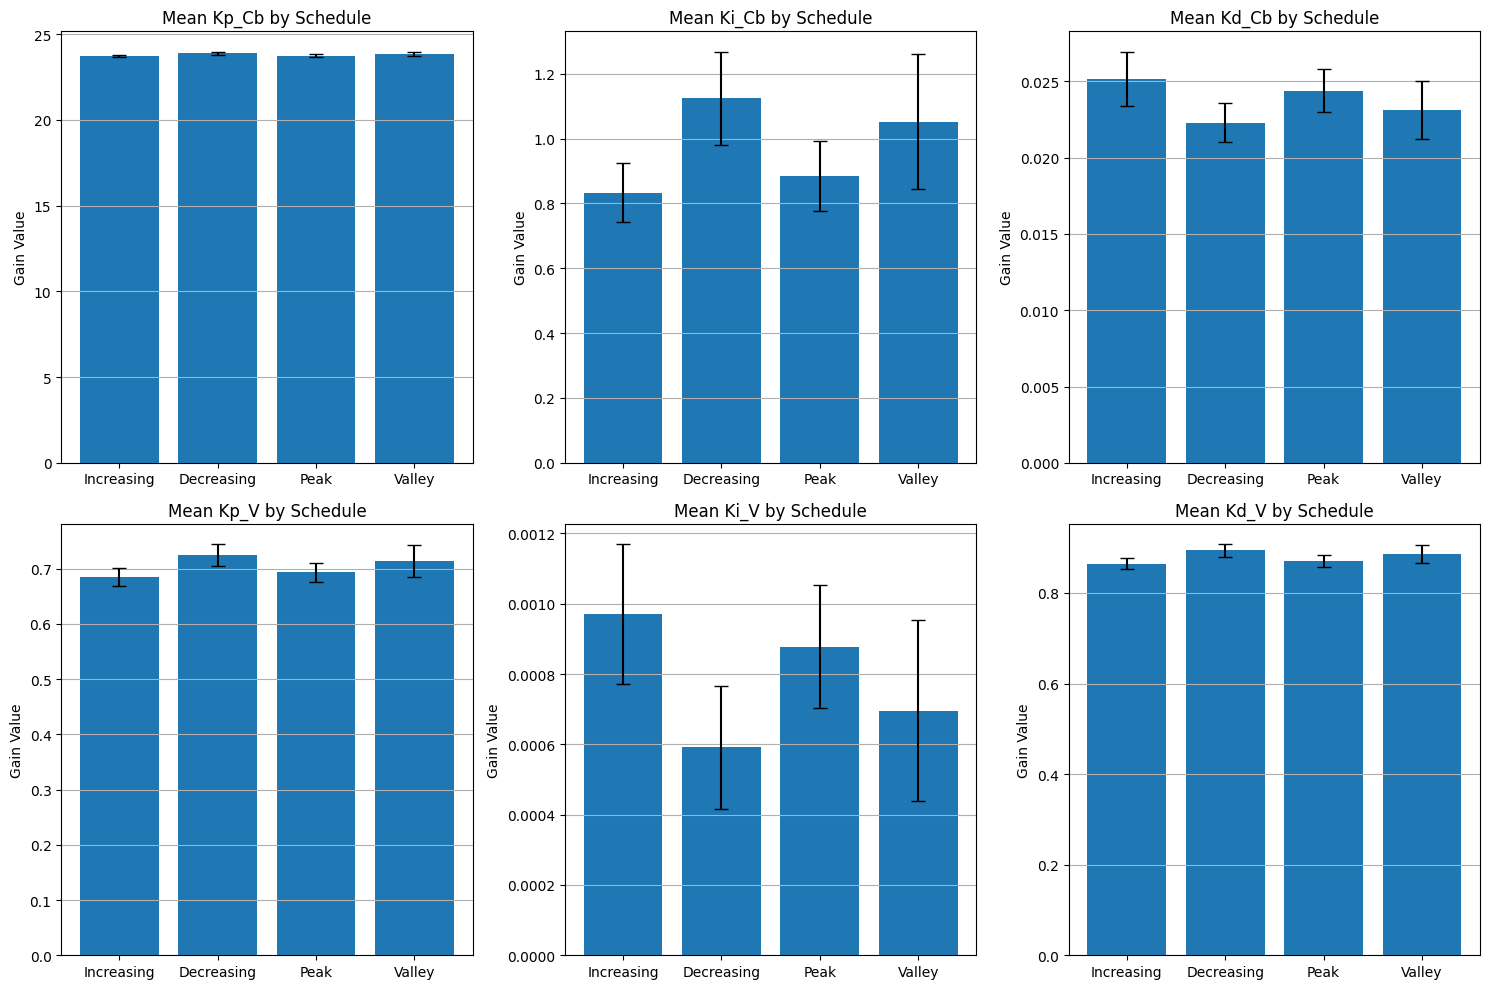

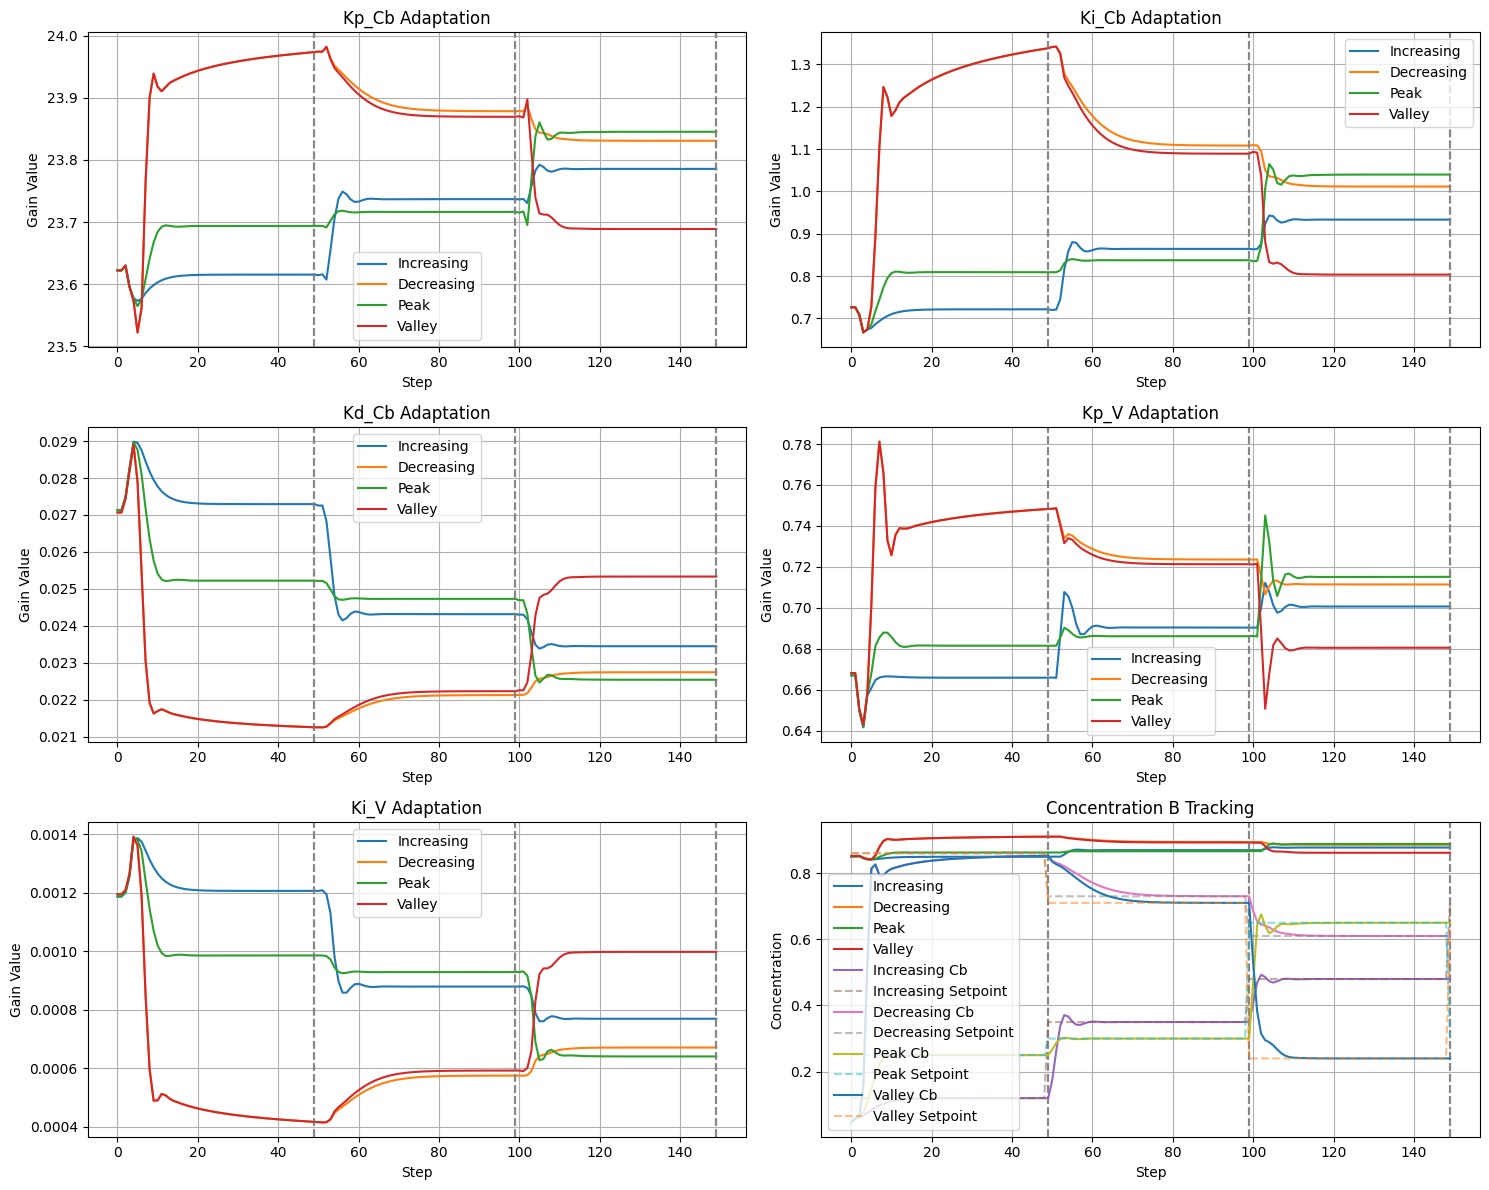

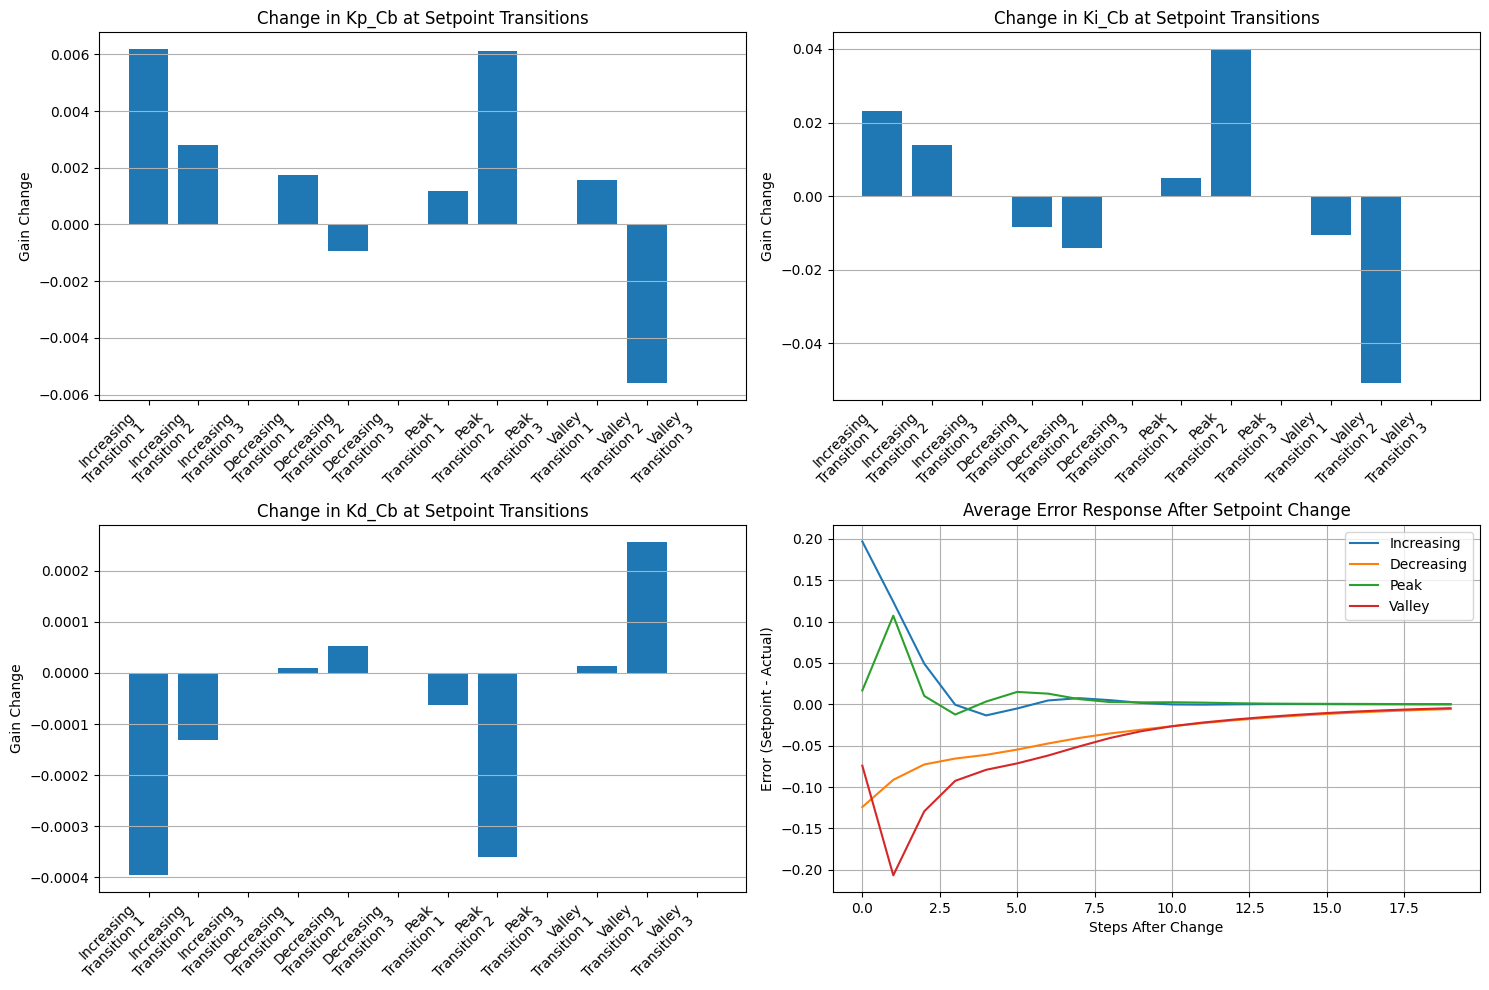

In [4]:
from cirl_visualization import analyze_pid_gain_patterns

if __name__ == "__main__":
    # Create environment
    env = CSTRRLEnv(
        simulation_steps=150,
        dt=1.0,
        uncertainty_level=0.0,
        noise_level=0.0,
        actuator_delay_steps=0,
        transport_delay_steps=0,
        enable_disturbances=False
    )
    
    # Load trained policy
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy = CIRLPolicyNetwork(state_dim=env.observation_space.shape[0], hidden_dims=[64, 64]).to(device)
    policy.load("./results/CIRL/models/cirl_policy_final.pt")
    
    # Run PID gain analysis
    analysis_results = analyze_pid_gain_patterns(policy, env, save_dir="./results/CIRL/test_plots")